### `setup`

In [74]:
import sys
import matplotlib.pyplot as plt

from ipywidgets import interact, widgets
from collections import namedtuple
from IPython.display import display
from graphviz import Digraph

# adapted from https://github.com/norvig/pytudes/blob/main/ipynb/Maze.ipynb
from Maze import random_maze, plot_maze, edge, neighbors4

# Chapter - Search

João Pedro Neto, DI/FCUL

## Introduction

Search is a very common problem in programming. The simplest examples occur when we are given a sequence of data and want to know if a given element exists and, if it does, in which position it is located. The two most typical searches are linear search and binary search.

To recap, in linear search, we need an iterator that traverses the data sequence until it finds the element or reaches the end of the sequence. The complexity of this algorithm is $\mathcal{O}(n)$.

Two implementations of linear search:

In [75]:
def linear_search(xs, y):
  for x in xs:
    if x==y:
      return True
  return False

assert linear_search([1,4,7,9], 4)

In [76]:
def linear_search(xs, y):
  for i,x in enumerate(xs):
    if x==y:
      return i
  return None

assert linear_search([1,4,7,9], 4) == 1

Binary search only works if the sequence is sorted, and the elements are comparable to each other. It's a more restricted search, but when it's possible to use, it guarantees better performance because the complexity of binary search is $\mathcal{O}(\log n)$.

The fundamental idea is to compare the element we're looking for with the middle of the list. This way, three outcomes can occur: (a) we're lucky, and the middle of the list is the element we want, (b) the middle of the list is smaller, and we need to search in the second half of the list, (c) the middle of the list is larger, and we need to search in the first half of the list.

If we repeat this process, in each iteration, the sublist to search reduces by half, ensuring logarithmic complexity.

The following image shows the search for value 12 in the given list. Notice how the search interval keeps shrinking with each comparison with the element in the middle of the remaining portion to explore:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/binary_search.jpg' width=450px></center>

Here's one implementation:

In [77]:
def binary_search(xs, y):
  i, j = 0, len(xs)-1
  while i <= j:
    mid = (i+j)//2  # middle index
    if xs[mid] == y:
      return mid
    if xs[mid] < y:
      i = mid+1
    else:
      j = mid-1
  return None

In [78]:
assert binary_search([1, 4, 7, 9], 4) == 1

### Use of `bisect` module

To perform binary search, Python provides module `bisect`.


In [79]:
from bisect import bisect, bisect_left, bisect_right

+ Function `bisect` receives an ordered indexed type and an element of that type, and returns the index where the element must be placed to maintain order.
+ Function `bisect_left` returns the insertion point to left of all elements with the same order
+ Function `bisect_right` returns the insertion point to right of all elements with the same order

In [80]:
xs = [10,20,30,50,60,70,80] # ordered list
idx = bisect(xs, 40)        # which index to insert 40?
print(idx)

3


In [81]:
idx = bisect('acdefg', 'b')
print(idx)

1


There are optional parameters `lo` and `hi` that specify the sublist to search where to insert:

In [82]:
xs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]

idx = bisect(xs, 7, lo=10, hi=None) # insert inside sublist xs[10:]
print(idx)

10


The function includes an optional `key` parameter, that allow us to use more complex comparisons between items:

In [83]:
records = [(1,'hannah'), (5,'john'), (7,'vicky'), (11,'theresa')] # ordered by id

# at what index in id 7?
bisect_left(records, 7, key=lambda p: p[0])

2

The key function is not applied to the search value implicitly, we need to invoke it:

In [84]:
xs = [0, 7, 14, 1, 8, 15, 2, 9, 3, 10, 4, 11, 5, 12, 6, 13] # order by remainder of division by 7

rem7 = lambda n: n%7
idx = bisect(xs, rem7(21), key=rem7) # need to use key() on 21 to search where to place it
print(idx)

3


An example that converts a numeric grade into a qualitative one:

In [85]:
def qualitative(grade, limits=[50,70,80,90], grades='FDCBA'):
  return grades[bisect_right(limits, grade)]

for grade in [55, 23, 82, 99, 80]:
  print(grade, '-->', qualitative(grade))

55 --> D
23 --> F
82 --> B
99 --> A
80 --> B


The next example checks if an ordered list includes a given prefix:

In [86]:
def has_prefix(words, prefix):
  idx = bisect_left(words, prefix)
  return words[idx].startswith(prefix) if 0<=idx<len(words) else False

words = ['and', 'begin', 'march', 'mount', 'wind', 'zebra']

assert     has_prefix(words, 'an')
assert not has_prefix(words, 'ab')
assert not has_prefix(words, 'mu')
assert not has_prefix(words, 'zu')

If we also need to insert the element, the module provides with `insort` functions. So instead of:

In [87]:
item, xs = 40, [10,20,30,50,60,70,80]

idx = bisect(xs, item)
xs.insert(idx, item)
xs

[10, 20, 30, 40, 50, 60, 70, 80]

we can simply do:

In [88]:
from bisect import insort

item, xs = 40, [10,20,30,50,60,70,80]

insort(xs, 40)
xs

[10, 20, 30, 40, 50, 60, 70, 80]

The next code inserts a value in a decreasing list,

In [89]:
xs = [20, 11, 10, 6, 0] # decreasing list
insort(xs, 8, key=lambda x: -x)
xs

[20, 11, 10, 8, 6, 0]

### Generalizing linear and binary search

Consider the following points:

1. The previous linear and binary searches traverse a structure, like a list, updating the position to explore. Each solution has its particular and well-defined strategy. Why not incorporate the update strategy into a parameter?

2. Do we really need to use a structure like a list? What if we want to search within a continuous range of numbers? Can't we search in a more general way?

3. Why always use equality in the search strategy? Why not generalize and provide any predicate $p$ that must be satisfied? Instead of returning the index where the solution is found, let's return the two indices that define the boundary, that is, the last index where $p$ is false and the first index where $p$ is true.

We assume that the structure (interval, sequence) under consideration is ordered according to a given criterion, in other words, it is monotonous.

Let's define a function `search` that receives:

+ two values, $L$ and $R$ defining the search space,
+ a predicate $p$ to satisfy,
+ a `next_` function with the strategy to calculate the next element/index to search (by convention, it should return `None` when the search is finished).

Here's a possible implementation:

In [90]:
def search(L, R, p, next_):
  while True:
    m = next_(L,R) # computes the next elemento to search
    if m is None:
      break        # the search ended
    if p(m):       # if m satisfies p,
      R = m        #   search [L,m]
    else:          # otherwise,
      L = m        #   search [m,R]
  return L,R

The linear search can then be defined as,

In [91]:
def linear_search(xs, y):
  next_ = lambda L,R: L+1 if R-L > 1 else None
  p     = lambda i: xs[i] >= y
  L, R  = search(-1, len(xs), p, next_)
  return R if R < len(xs) and xs[R] == y else None

The `next_` function specifies that, given bounds $L$ and $R$, we should search at the next index, $L+1$, unless there are no more elements to search (i.e., when $L+1=R$). The second situation occurs because we have either found the boundary of $p$ or reached one of the original boundaries, which indicates that we haven't found an element that satisfies $p$.

In [92]:
xs = [1,2,3,4,4,4,5,6,7]
assert linear_search(xs, 5) == 6
assert linear_search(xs, 8) is None

We can also define binary search using `search`,

In [93]:
def binary_search(xs, y):
  mid = lambda L,R: (L+R)//2 if R-L > 1 else None
  p   = lambda i: xs[i] >= y
  L, R  = search(-1, len(xs), p, mid)
  return R if R < len(xs) and xs[R] == y else None

The only change is in the new strategy definition, which represents the essence of binary search.

In [94]:
xs = [1,2,3,4,4,4,5,6,7]
assert binary_search(xs, 5) == 6
assert binary_search(xs, 8) is None

This code organization makes it more explicit what the linear and binary searches have in common and what sets them apart.

The use of the predicate `p` opens up new possibilities. We can search for more complex patterns. 

The following function calculates $\sqrt{x}$ using binary search:

In [95]:
def sqrt_search(x):
  mid  = lambda L,R,ε=1e-9: (L+R)/2 if R-L > ε else None
  p    = lambda i: i*i >= x
  L, R = search(0, max(x,1), p, mid)
  return R

In [96]:
from math import isclose

assert isclose(sqrt_search(2),    2**0.5)
assert isclose(sqrt_search(0.25), 0.25**0.5)

<font size="+4" color="blue;green"><b>?</b></font> Use the `search` function to calculate $x$ such that $x^x = y$, with a maximum error of nine decimal places, given a positive value $y \geq 0.775$.

In [97]:
def power_x(y):
  ...

In [98]:
y = 10
x = power_x(y)
assert isclose(x**x, y)

y = 0.775  # for smaller values, the function in no longer monotonous
x = power_x(y)
assert isclose(x**x, y)

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'NoneType'

We just created a function that generalizes both linear and binary searches. However, we don't have to stop at this result. What if we want to search in spaces that are not numerical or have more than one dimension?

In the next sections we will explore techniques that greatly expand the universe of problems we can solve with search algorithms.

## Searching for Solutions

Searching is a vast subject that is not limited to finding elements in a sequence or interval. A much more interesting application is the resolution of arbitrary search problems.

Now, we won't be limited to searching in lists or numeric intervals. Our goal is to solve problems in which we can represent candidates for the solution in a data structure, and there is some mechanism that allows us to explore possible candidates to find one that is a solution.

To make this subject more concrete, let's start with some terminology:

+ A **search space** $S$ is a set of values (also referred to as candidates or states) that satisfy the problem's requirements.

+ The **objective function** (also called a cost function or utility function) is a criterion that maps each candidate to a numeric value.

+ A **solution** is a candidate from $S$ considered optimal according to the objective function.

There can be zero, one, or more solutions. If there are no solutions, the problem is considered **unsolvable**.

An example: consider the problem of maximizing the expression $x^2 + y$, knowing that $1 \leq x \leq 10$, and $2 \leq y \leq 5$.

In this case, there are two requirements given by the allowable value intervals for $x$ and $y$. The search space $S$ consists of all pairs $(x, y)$ that satisfy these requirements.

$$S = \{ (x, y) : 1 \leq x \leq 10, 2 \leq y \leq 5 \}$$

For example, $(1, 2) \in S$, but $(1, 1) \notin S$.

The objective function is

$$f(x, y) = x^2 + y$$

A solution to this problem is a pair $(x^*, y^*) \in S$ whose value of the expression $x^2 + y$ is as large as possible.

$$(x^*, y^*) = \underset{x, y}{\text{argmax}} ~ f(x, y)$$

In this case, there is a unique solution in the pair $(10, 5)$ with $f(x^*, y^*) = f(10, 5) = 105$.

Traditionally, searches for solutions are divided into the following categories:

+ In an **optimization problem**, we search for the optimal solution (relative to a criterion, as seen in the previous example).

+ In a **decision problem**, we search for the existence of a solution. Here, the objective function is often a predicate, partitioning the candidates into solutions and non-solutions, without a preference between existing solutions. This type of approach is useful in problems where optimizing the solution is not required. For example, if we want to find a path that leads us out of a maze, we may be satisfied with the first solution found, we may not necessarily need the shortest path.

+ In an **enumeration problem**, we search for all solutions. Here, the objective function is not important because there is no need to choose between the solutions found. We need to be careful in this case, as the number of solutions can be extremely large.

Between Mathematics (e.g., in [Operations Research](https://en.wikipedia.org/wiki/Operations_research) or [Mathematical Optimization](https://en.wikipedia.org/wiki/Mathematical_optimization)) and Computer Science (e.g., in [Artificial Intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence)), there exists an extensive array of different techniques for solving these types of problems.

In the following sections, we will introduce some search algorithms that can be used to find solutions in a wide variety of problems, whether they are optimization, decision, or enumeration problems.

## Backtracking Search

How to explore a solution space?

One possibility is the so-called _brute force_ approach: list all possible candidates and evaluate each one individually. This approach is straightforward to explain and implement, but it has the disadvantage of leading to algorithms with very high complexity.

As a result, these programs are too slow to be practical.

Backtracking search follows a different approach. Instead of enumerating candidates blindly, it creates partial candidates and checks if they make sense according to the problem's requirements. In other words, it doesn't construct a candidate in its entirety but adds a little bit at a time. At each addition, it checks if it is not creating a value outside the solution space.

If this occurs, if we have an invalid partial candidate, we stop this branch of computation and backtrack to try other possibilities.

To better understand this search and the way we need to think, let's solve some famous problems.

### The Eight Queens

This is the classic puzzle of placing eight queens on a chessboard without any of them attacking the others.

The following diagram shows one possible solution:

In [ ]:
# show queen solution
def showQueens(queens, sz=0.25):
  styles = {
    'white': {'shape': 'square', 'width': str(sz),  'fixedsize': 'true', 'style': 'filled', 'color': 'white'},
    'black': {'shape': 'square', 'width': str(sz),  'fixedsize': 'true', 'style': 'filled', 'color': 'lightgray'}
  }
  g = Digraph(engine="neato")
  dim = len(queens)
  for i in range(dim):
    for j in range(dim):
      style = 'white' if (i+j) % 2 == 0 else 'black'
      piece = '♛' if (queens[i]==j) else ''
      coord = str(sz*i)+','+str(sz*(dim-j))+'!'
      g.node(str(i)+','+str(j), piece, styles[style], pos=coord)
  display(g)

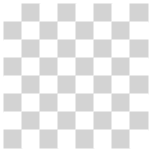

In [ ]:
showQueens([6,4,2,0,5,7,1,3], 0.25)

How to represent a chessboard with queens? It's not always easy to find a good representation for the problem. This decision is crucial because a good representation makes the implementation easier and even has consequences in the algorithm's efficiency.

The chosen option here is to represent the board with lists of numbers. Each list index corresponds to a column, and each number indicates the position -- i.e., the row -- of the queen in that column. The representation of the previous board is given by the list `[6, 4, 2, 0, 5, 7, 1, 3]`.

This representation saves memory (only eight numbers to represent 64 squares) and enforces an invariant: by definition, there can't be two queens in the same column.

It also helps us define partial candidates. For example, the list `[3, 1, 7]` represents the situation where we have placed only the first three queens:

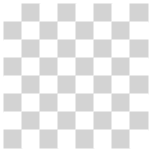

In [ ]:
showQueens([3,1,7,-1,-1,-1,-1,-1]) # -1 means empty column

Now we need a function that tells us whether a representation of the chessboard state respects the puzzle. In other words, whether the queens already placed attack each other or not.

The `isValid` predicate checks if the queen at index `n` attacks the previous ones. Notice that it doesn't check between all queens. We will see that this validation is sufficient for the algorithm we are going to implement.

In [ ]:
def isValid(state, n):
  for i in range(n):
    if ( state[i] == state[n] or         # if there's a queen in the same row
         state[i] - state[n] == n - i or #  or in the same / diagonal
         state[n] - state[i] == n - i ): #  or in the same \ diagonal
      return False
  return True

In [ ]:
# invalid: a 4th queen (index 3) attacks the 1st queen (index 0)
assert not isValid([3,1,7,0], 3)

The next function implements the search. The central idea is to create a proposal of a candidate, step by step. The function does this by placing one queen on the board at a time. In other words, these are *partial candidates* (the queens are not all placed yet).

And now, here's the trick that makes this work: *if a partial candidate is invalid, there's no need to continue down that path*. This will save us a lot of computation because we avoid constructing candidates that we already know in advance are invalid.

If we create a complete candidate that has been validated at every step, then we have found a solution!

This search technique, where we backtrack when we encounter invalid partial candidates, is called **backtracking**.

In [ ]:
def backtrackQueens(n=8, state=None, col=0):
  """  n     : board size
       state : current board
       col   : the column to place the next queen
    requires : 0 < n < ~25 (greater values take too long to compute) """
  if state is None:
    state = [0]*n

  if col == n:
    yield state               # found a complete solution
  else:
    for i in range(n):        # for each board column,
      state[col] = i          #  place current queen at i-th row
      if isValid(state, col): #  if this placement is valid
        yield from backtrackQueens(n, state, col+1)  # place next queen

Let's find a solution:

In [ ]:
gen = backtrackQueens(8)

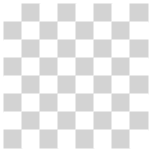

In [ ]:
showQueens(next(gen)) # rerun it for more solutions

### A General Backtracking Algorithm

After studying this first example, we can highlight the components necessary for a backtracking search to work:

+ An initial candidate that starts the search.

+ A predicate that determines whether a partial candidate is valid or not.

+ A predicate that determines whether a candidate is a solution.

+ A function capable of generating the next parts of the candidate.

Let's organize these requirements into an abstract class. We will denote candidates as _states_:

In [ ]:
from abc import ABC, abstractmethod

class BacktrackProblem(ABC):
  @abstractmethod
  def start(self): ...

  @abstractmethod
  def reject(self, state): ...

  @abstractmethod
  def accept(self, state): ...

  @abstractmethod
  def next_moves(self, state): ...

In the Queens example, the initial candidate was an empty chessboard, the `isValid` predicate validated the correctness of a partial candidate, and it implicitly validated the solution if we advanced to the last Queen. Lastly, the generation of new candidates corresponded to placing the Queen in the various rows of the next column of the chessboard.

However, this approach is very ad-hoc. It would be better to separate the essence of the backtracking search algorithm from the problem details.

The general search function should be capable of finding a solution to a problem if we provide it with all the necessary problem-specific data. In our case, we can achieve this by passing a properly filled `BacktrackProblem` object.

The following `backtrack` function receives a problem and applies a backtracking search to find solutions. It has been designed as a generator, which means we can request as many solutions as we want (as long as they exist, of course).

Since we will have a cache to avoid repeating calculations, the choice of the state representation must be immutable (or Python will complain).

In [ ]:
def backtrack(problem, state=None, cache=None):
  # state : current state/candidate (must be immutable)
  # cache : set of previous candidates
  if state is None:
    state = problem.start()
    cache = set()

  if not problem.reject(state):            # if the state is not rejected,
    if problem.accept(state):              #  check if it is a solution
      yield state                          #  if so, yield it
    else:
      for s2 in problem.next_moves(state): # otherwise, build more of the state
        if s2 not in cache:                # and if it is a new original state,
          cache.add(s2)                    #  cache it to prevent infinite loops
          yield from backtrack(problem, s2, cache) #  and search it

### The Eight Queens (again)

We define the Queens _puzzle_ as a subclass of `BacktrackProblem`,

In [ ]:
class Queens(BacktrackProblem):
  def __init__(self, n):
    self._n = n

  def start(self):
    return tuple() # state is a tuple to be added in set 'cache'

  def reject(self, state):
    last = len(state)-1
    for i in range(last):
      if ( state[i]   == state[last] or           # same row
           state[i]    - state[last] == last-i or # same diagonal /
           state[last] - state[i]    == last-i ): # same diagonal \
        return True
    return False

  def accept(self, state):
    return len(state) == self._n

  def next_moves(self, state):
    return [state+(i,) for i in range(self._n)]

Each component of the problem is described separately. The constructor of the `Queens` class returns a `BacktrackProblem` object with everything necessary to perform the search.

Helper function `solveQueens` finds and prints a solution for a $n\times n$ board:

In [ ]:
def solveQueens(n):
  try:
    showQueens(next(backtrack(Queens(n))))
  except StopIteration:
    print(f'No solution for {n} queens.')

No solution for 3 queens.


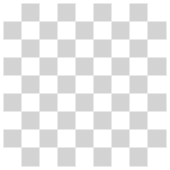

In [ ]:
solveQueens(3)
solveQueens(9)

Separation of responsibilities helps keep the code organized and also makes it easier for us to reuse it.

Now, let's use the `backtrack` function to solve a completely different puzzle.

### The Two Jugs


<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/jugs.png' width=400px></center>

This is a puzzle where you have two buckets or containers (jugs) with different capacities. You can empty them, fill them completely, or pour as much as possible from one into the other until the second one is full. This results in six different operations to choose from.

The puzzle asks you to find a valid sequence of actions to obtain an exact amount of liquid.

For example, with two jugs with capacities of four and three liters, what should we do to obtain two liters?

What do we need to specify this problem?

First, what is a state in this problem? The important information is how many liters each bucket has. We encode this in a pair of integers. But because we want to know what moves are needed to reach the goal, our state will be a sequence of pairs, from the initial state (both buckets empty) to the current state, which we hope will lead to solving the puzzle (i.e., one of the buckets has the desired amount).

So, our choice is to represent a state as a tuple with multiple pairs (we can't use a list of pairs because lists are mutable).

+ The initial state starts with both buckets empty, so it's given by the value `((0, 0),)`, i.e., a tuple with only the pair `(0, 0)`.

+ The rejection function will not accept states with repeated pairs. We cannot accept these to avoid infinite loops (this would represent a circular sequence of bucket fillings).

+ The acceptance function will only accept states where the last pair has one of the buckets with the correct amount of liters.

+ Finally, the function that generates new states must consider the six possible moves (pour from one of the two buckets, fill one of the two buckets, transfer from one bucket to the other).

Now, let's take a deep breath and write these four components in a class:

In [ ]:
class Jugs(BacktrackProblem):
  def __init__(self, goal, cap1, cap2):
    self._goal = goal
    self._cap1 = cap1
    self._cap2 = cap2

  def start(self):
    return ((0,0), )

  def reject(self, state):
    return state[-1] in state[:-1] # reject if last pair is repeated

  def accept(self, state):
    return self._goal in state[-1] # accept solution only if the goal is achieved

  def next_moves(self, state):
    cap1, cap2 = self._cap1, self._cap2
    jug1, jug2 = state[-1] # get current jugs
    moves = [(cap1, jug2), (jug1, cap2), (0, jug2), (jug1, 0)]
    if jug1 > 0 and jug2 < cap2:
      transfer = min(cap2 - jug2, jug1)
      moves.append( (jug1-transfer, jug2+transfer) )
    if jug2 > 0 and jug1 < cap1:
      transfer = min(cap1 - jug1, jug2)
      moves.append( (jug1+transfer, jug2-transfer) )
    return [state+(move,) for move in moves] # adding each one of six possible moves

In [ ]:
# show Jugs puzzle solutions 
def drawJugs(moves):
  styles = {
    'ref': {'shape': 'invtrapezium', 'width': '.25',  'fixedsize': 'true'},
    'val': {'shape': 'ellipse'}
  }
  g = Digraph(engine="neato")
  xcoord = 0

  for (i,(j1,j2)) in enumerate(moves):
    g.node('cup1'+str(i), str(j1), styles['ref'], pos=str(xcoord)    +',0!')
    g.node('cup2'+str(i), str(j2), styles['ref'], pos=str(xcoord+0.3)+',0!')
    xcoord = xcoord + 0.75

  for i in range(1,len(moves)):
    g.edge('cup2'+str(i-1), 'cup1'+str(i), penwidth ='.5', arrowsize='.5')

  display(g)

# A função `showJugs` resolve o problema e mostra a primeira  solução encontrada.
def showJugs(goal, cup1, cup2):
  try:
    gen = backtrack(Jugs(goal, cup1, cup2))
    drawJugs(next(gen))
  except StopIteration:
    print("Não há solução!")

We can now find solutions for instances of this puzzle.

> <i>With two jugs of four and three liters, how can we obtain two liters?</i>

Let's find the solution for this problem.

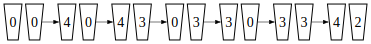

In [ ]:
showJugs(2, 4, 3)

yes! 💪

On this [page](https://m4maths.com/20059-You-have-two-buckets-of-11-liter-and-6-liter-How-can-you-measure-exactly-8-liter.html), we find the following question:

> <i>You have two buckets of 11 liter and 6 liters. How can you measure exactly 8 liters?</i>

This is another instance of the general problem; only the values have changed. We are prepared for this:

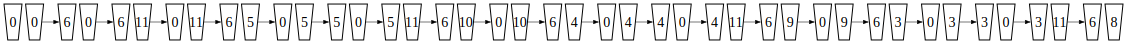

In [ ]:
showJugs(8, 6, 11)

And [this](http://numb3rs.wolfram.com/501/puzzle.html):

> <i>You have a 7 liter bottle, an 11 liter bottle, and a bathtub filled with water. How can 2 liters of water be measured into the smaller bottle?</i>

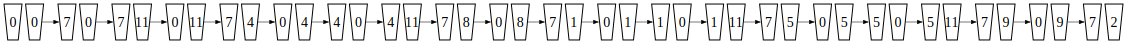

In [ ]:
showJugs(2, 7, 11)

One [more](https://www.mathsisfun.com/puzzles/measuring-6-liters-solution.html):

> <i>You are going to mix up some concrete, and in order to get it just right you need exactly 6 liters. But you only have a 4-liter and a 9-liter bucket.</i>

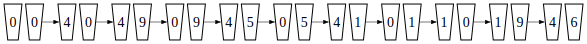

In [ ]:
showJugs(6, 4, 9)

They are falling like flies!

Notice the advantage of using function parameters to represent the initial values of the puzzle. This is a very effective method for reusing code to solve similar problems.

And since we implemented a generator, we can list all possible solutions for a given instance of the problem:

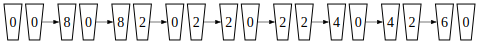

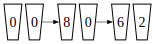

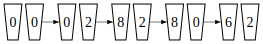

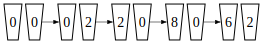

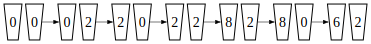

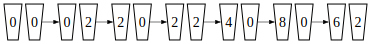

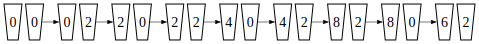

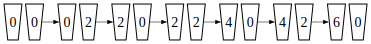

In [ ]:
for solution in backtrack(Jugs(6, 8, 2)):
  drawJugs(solution)

## Breadth Search

Let's assume we have the following information:

+ An **initial state** from which to start the search.

+ One or more **final states** to terminate the search.

+ A **transition function** that, given a state, returns a sequence of next states.

These three elements, when combined, *turn the search space into a tree*!

Here's an example for Tic-Tac-Toe, where the initial state is the empty board, and the transition function is defined according to the rules of the game:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/tree_tictactoe_full.png' width=500px></center>

> this diagram is not technically a tree, but it could be transformed into one by duplicating some of the branches.

The realization that we can interpret a search problem as if it were a tree is of utmost importance in computer science.

A very important consequence is that we can use tree traversal techniques to search for solutions in many different types of problems, *as long as we know how to convert the problem into this format*.

We can traverse trees in depth and breadth. In this section, we will focus on breadth-first traversal.

Some points:

+ We will analyze one state at a time. Therefore, we need to store the states that are waiting for analysis. The set of states waiting for analysis is called the **frontier**. If the frontier becomes empty without finding a solution, the search has failed!

+ The frontier will be stored in a waiting queue. The state that has been waiting the longest will be the next to be analyzed.

+ Analyzing a state involves performing the following tasks:

  1. Check if it is one of the final states. If it is, we terminate the search and return the appropriate answer. If not:
  1. Calculate its next states using the transition function.
  1. For each next state, if we haven't encountered it yet, we store it in the queue, i.e., we add it to the frontier.
  + It is important not to put a state back in the queue if it has already been there, as we risk entering an infinite loop.
  + From the perspective of the tree, this care corresponds to not entering repeated branches, resulting in faster searching.

This algorithm is called **breadth-first search** or **BFS**.

The following abstract class defines the methods to implement in order to define a search problem:

+ `start` returns the initial state.

+ `is_goal` is a predicate that checks if a given state is a final state.

+ `next_moves` is the transition function.

In [ ]:
from abc import ABC, abstractmethod

class TreeSearchProblem(ABC):
  @abstractmethod
  def start(self): ...

  @abstractmethod
  def is_goal(self, state): ...

  @abstractmethod
  def next_moves(self, state): ...

Function `bfs` receives an object of this class, and executes the BFS algorithm:

In [ ]:
from collections import deque

def bfs(problem):
  start, next_moves, is_goal = problem.start(), problem.next_moves, problem.is_goal

  frontier = deque([start])    # current states to evaluate, FIFO access
  paths = {start: [start]}     # path[s] gives the path from start to s
  while frontier:              # while there are states in the frontier,
    s = frontier.popleft()     #  get first state in the frontier
    if is_goal(s):             #  if it's the goal, the search ended
      yield paths[s]
    else:
      for s2 in next_moves(s): #  if it's not the goal, iterate all next moves from s,
        if s2 not in paths:    #   if it is a new state,
          frontier.append(s2)  #    add it to frontier
          paths[s2] = paths[s] + [s2]  # and create a new path for s2 based on path s

Variable `paths` is a dictionary used to store the path from the initial state `start` to each of the analyzed states. When we find a final state, its complete path, starting from the initial state, will be returned.

### Solving a Labyrinth

Our use case will be solving a maze.

To help us, the `random_maze` function creates a random maze, and `plot_maze` uses the `matplotlib` module to visualize the maze (both imported from the `maze_maker` module). These mazes always start at coordinate `(0,0)` and end in the opposite corner.

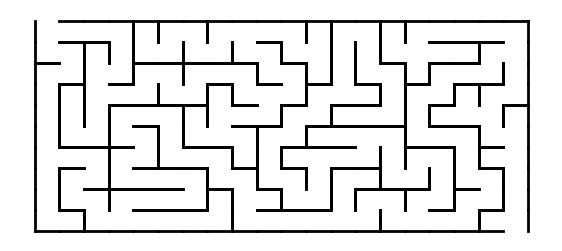

In [ ]:
M = random_maze(20, 10, seed=101)
plot_maze(M, figsize=(7, 3))

How can we represent this problem in a format that function `bfs` can recognize? This is the demanding part for the programmer.

+ A state is a position within the maze. A state will be represented by a pair `(row, column)`.

+ A valid move is moving from the current position to a neighboring position as long as there is no wall between them. This is defined in the `valid_steps` function. The function takes a position and returns a list of valid neighboring positions.

+ The `is_goal` function takes a position and checks if it is the opposite corner of the maze.

In [ ]:
# From module maze_maker:
#  * A maze is a triple (maze.width, maze.height, maze.edges) where maze.edges
#    is a list of pairs of cells defining which are the valid paths
#    between adjacent cells. A cell is a pair (row, column)
#  * neighbors4() receives a cell and return its adjacent neighbors
#  * edge() returns the ordered pair of two cells
class MazeSolver(TreeSearchProblem):
  def __init__(self, maze):
    self._maze = maze

  def start(self):
    return (0,0) # the initial cell

  def is_goal(self, state):
    return state == (self._maze.width-1, self._maze.height-1)

  def next_moves(self, state):
    return [s1 for s1 in neighbors4(state) if edge(state,s1) in self._maze.edges]

With this representation we are ready to execute the search:

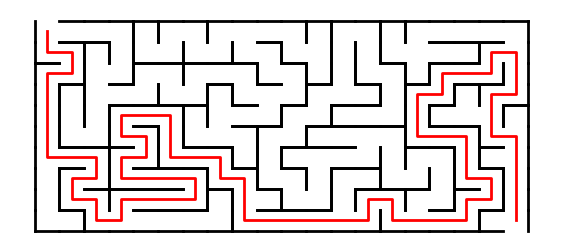

In [ ]:
solution = next(bfs(MazeSolver(M)))
plot_maze(M, figsize=(7, 3), path=solution)

<font size="+2">🤩</font>

The following animation allows us to visualize the computation that took place.

For each step, we observe the path to the current state. The green dots represent the states stored in the frontier for that particular step:

In [ ]:
def show(passo, paths, frontiers):
  plot_maze(M, figsize=(7,3), path=paths[passo], frontier=frontiers[passo])
  plt.show()

paths, frontiers = breadth_paths(M)
interact(lambda passo : show(passo, paths, frontiers),
         passo = widgets.IntSlider(min=1, max=len(paths)-1, value=1,
                                   continuous_update = False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='passo', max=190, min=1), Output…

Breadth-first search does not commit to any path. It analyzes the entire frontier, one state at a time. This ensures that the first solution found is the shortest among all possible paths (from the initial state to the final state). It's a very safe search, remaining robust even in the presence of infinite corridors in the maze.

The price to pay for not taking risks is that it tends to be slower in finding a solution. Another problem is the risk of the frontier growing too large, as we may run out of space to store all pending states.

### Enumerating Solutions

Instead of returning the first solution, we can request all solutions from the generator.

Let's consider an application: given a list of numbers, we want to find all possible combinations of those numbers that add up to a given value.

For example, if the list is `[2,3,4,5]`, and we want to sum to `10`, there are several possible solutions such as `(5,5)`, `(3,3,4)`, `(2,2,3,3)`, and so on.

As long as we can incorporate the problem requirements into the `start`, `next_moves`, and `is_goal` methods, the search will give us the desired result:

In [ ]:
class SameSumSublists(TreeSearchProblem):
  def __init__(self, values, total):
    self._values = values
    self._total = total

  def start(self):
    return tuple()

  def is_goal(self, state):
    return sum(state) == self._total

  def next_moves(self, state):
    return [state+(n,) for n in self._values if sum(state)+n <= self._total]

Since we are not defining an ordering, there will be duplicate solutions. Let's use a set to remove repetitions and print distinct solutions only:

In [ ]:
def showReport(values, total):
  return { tuple(sorted(path[-1]))
           for path in bfs(SameSumSublists(values, total)) }

showReport([2,3,4,5], 10)

{(2, 2, 2, 2, 2),
 (2, 2, 2, 4),
 (2, 2, 3, 3),
 (2, 3, 5),
 (2, 4, 4),
 (3, 3, 4),
 (5, 5)}

As happened with `backtrack`, we are no longer thinking about the search algorithm. We are trying to describe the problem in a form that the `bfs` search algorithm can work with. This type of programming, where we focus on representing the problem and not solving it — because we have a general algorithm for solving it — is called **declarative programming**.

> If you're curious, here are some of the most famous declarative languages:
>
> + [SQL](https://en.wikipedia.org/wiki/SQL), used to manipulate and query relational databases.
>
> + [Regular Expressions](https://en.wikipedia.org/wiki/Regular_expression) (_regex_), used to describe patterns of symbols for text searches.
>
> + [Prolog](https://en.wikipedia.org/wiki/Prolog), a programming language used in artificial intelligence, inspired by first-order logic in mathematics.

## Depth Search

The "sibling" of breadth-first search is depth-first search.

Instead of searching the frontier by taking one step in each of its states, we can select one state and explore it completely before moving on to the next. This strategy is called **depth-first search** or **DFS**.

The algorithm used to describe DFS is almost identical to that of BFS. The only modification required is in the policy of accessing the frontier states. In BFS we used a queue, while in DFS we must use a stack!

In [ ]:
from collections import deque

def dfs(problem):
  start, next_moves, is_goal = problem.start(), problem.next_moves, problem.is_goal

  frontier = deque([start])
  paths = {start: [start]}
  while frontier:
    s = frontier.pop() # the FIFO access is the only difference from bfs
    if is_goal(s):
      yield paths[s]
    else:
      for s2 in next_moves(s):
        if s2 not in paths:
          frontier.append(s2)
          paths[s2] = paths[s] + [s2]

To compute the solution using depth-first search, we apply the same parameters we used in breadth-first search:

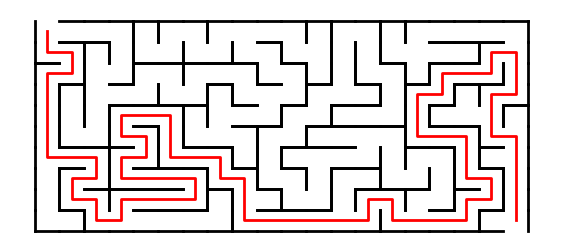

In [ ]:
solution = next(dfs(MazeSolver(M)))
plot_maze(M, figsize=(7,3), path=solution)

We can also explore this computation in the following animation:

In [ ]:
def show(passo, paths, frontiers):
  plot_maze(M, figsize=(7,3), path=paths[passo], frontier=frontiers[passo])
  plt.show()

paths, frontiers = depth_paths(M)
interact(lambda passo : show(passo, paths, frontiers),
         passo = widgets.IntSlider(min=1, max=len(paths)-1, value=1,
                                   continuous_update = False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='passo', max=140, min=1), Output…

If DFS enters the correct path, it becomes very effective since it doesn't explore the other states in the frontier. Backtracking is of a similar nature to DFS. Backtracking also focuses on a candidate and only moves to others when the current candidate is rejected or turned into a solution.

Unlike BFS, DFS can return a path that is not the shortest possible. Another drawback is that if the search enters a path with no end, DFS cannot escape from it, and the computation will not terminate.

These disadvantages stem from DFS's inability to penalize excessively long paths and its inability to choose more promising paths (BFS shares this second limitation). We will now see an algorithm that attempts to address these issues.

## Heuristic Search

In certain problems, we may have access to additional information that aids in exploring the search space. It's not enough information to immediately solve the problem, but it helps us choose the next candidate.

When we incorporate this knowledge into a function that helps us choose candidates, we call this function a **heuristic**.

There are several heuristic search algorithms. Let's introduce one of the most famous: the $A^*$ search (pronounced "A-star").

Like BFS and DFS, $A^*$ maintains a frontier of candidates to explore. But unlike BFS (which uses a regular queue) and DFS (which uses a stack), $A^*$ uses a priority queue.

The priority of state $s$ is a function of two values:

- The cost $g(s)$ of the path from the start to $s$.
- An estimate $h(s)$ of the cost from $s$ to the solution.

In the priority queue, for each candidate $s$, we add the value $g(s) + h(s)$, which determines its position in the queue (and since they are costs, lower is better).

The heuristic, for the search to work, must return zero for all candidates that are solutions.

So, for $\text{A}^*$ to perform a search, the problem needs to specify the following elements:

+ an initial state where the search begins.

+ a function that, given a state, returns the next states.

+ a cost function that, given a state and a neighboring state, informs us of the cost of transitioning from one state to another.

+ a heuristic function that, given a state, provides an estimate of the cost to reach the solution.

Once again, we create an abstract class for this purpose:

In [ ]:
from abc import ABC, abstractmethod

class HeuristicProblem(ABC):
  @abstractmethod
  def start(self): ...

  @abstractmethod
  def next_moves(self, state): ...

  @abstractmethod
  def cost(self, state, next_state): ...

  @abstractmethod
  def heuristic(self, state): ...

Function `a_star` implements this algoritm:

In [ ]:
from heapq import heappop, heappush

def a_star(problem):
  """ Find a shortest sequence of states from start to a goal state """
  start, next_moves = problem.start(), problem.next_moves
  heuristic, cost = problem.heuristic, problem.cost

  frontier  = [(heuristic(start), start)] # priority queue sorted by path length f(s)=g(s)+h(s)
  previous  = {start: None}               # start state has no previous state; other states will
  path_cost = {start: 0}                  # the cost of the best path to a state
  path      = lambda s: ([] if (s is None) else path(previous[s])+[s])

  while frontier:
    f, s = heappop(frontier)
    if heuristic(s) == 0:
      return path(s)
    for s2 in next_moves(s):
      g = path_cost[s] + cost(s, s2)
      if s2 not in path_cost or g < path_cost[s2]:
        heappush(frontier, (g + heuristic(s2), s2))
        path_cost[s2] = g
        previous[s2] = s

We'll solve the maze problem again, taking into account the additional information we have about the maze's dimensions and the location of the exit in the opposite corner. This information allows us to create a heuristic that estimates the cost to reach the solution: _the closer a cell is to the opposite corner, the more promising it is_.

We can use the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) metric, which calculates the distance by summing the number of rows and columns between two positions. In terms of the cost of the path, we'll assume that all steps to neighboring cells have the same cost, which is 1.

In [ ]:
class HeuristicMazeSolver(HeuristicProblem):
  def __init__(self, maze):
    self._maze = maze

  def start(self):
    return (0,0)

  def next_moves(self, s):
    return [s1 for s1 in neighbors4(s) if edge(s,s1) in self._maze.edges]

  def cost(self, s1, s2):
    return 1 # each move always costs 1

  def heuristic(self, s):
    return abs(s[0]-(self._maze.width-1)) + abs(s[1]-(self._maze.height-1))

Let's solve the maze with this search:

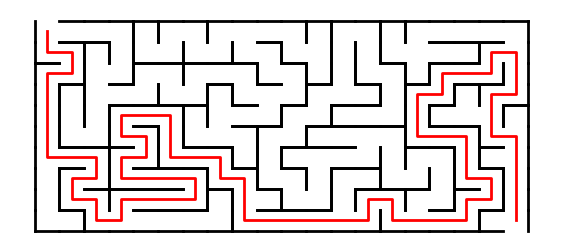

In [ ]:
solution = a_star(HeuristicMazeSolver(M))
plot_maze(M, figsize=(7,3), path=solution)

Breadth-first search is a specific case of $A^*$ search where the heuristic function is a binary function that returns 0 if the state is a goal state, or 1 otherwise. In other words, BFS corresponds to the situation where the heuristic of A* is not informative during the search.

To illustrate this relationship, the following class takes a `TreeSearchProblem` object and converts it into a `HeuristicProblem` object:

In [ ]:
class TreeSearch2Heuristic(HeuristicProblem):
  def __init__(self, problem):
    self._problem = problem

  def start(self):
    return self._problem.start()

  def next_moves(self, s):
    return self._problem.next_moves(s)

  def cost(self, s1, s2):
    return 1 # each move always costs 1

  def heuristic(self, s):
    return 0 if self._problem.is_goal(s) else 1  # h(goal)==0, h(not goal)==1

We now can use the `a_star` function to have the same behavior as the `bfs` function:

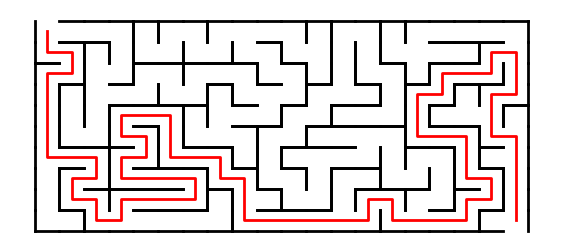

In [ ]:
solver = TreeSearch2Heuristic(MazeSolver(M))
solution = a_star(solver)
plot_maze(M, figsize=(7,3), path=solution)

$\text{A}^*$ search is very flexible and can solve a wide range of different problems.

As an example of this flexibility, let's solve two variants of the maze problem.

First variant. We have two types of movement:

  + Moving normally to a neighboring space costs 1 credit.
  + Drilling through the wall to go to the other side costs 20 credits.

How to find the minimum cost path? We need to represent this new rule in the cost function:

In [ ]:
class WallMazeSolver(HeuristicProblem):
  def __init__(self, maze, wallCost):
    self._maze = maze
    self._wallCost = wallCost

  def start(self):
    return (0,0)

  def next_moves(self, s):
    return neighbors4(s) # no limitations here

  def cost(self, s1, s2):
    return 1 if edge(s1,s2) in self._maze.edges else self._wallCost

  def heuristic(self, s):
    return abs(s[0]-(self._maze.width-1)) + abs(s[1]-(self._maze.height-1))

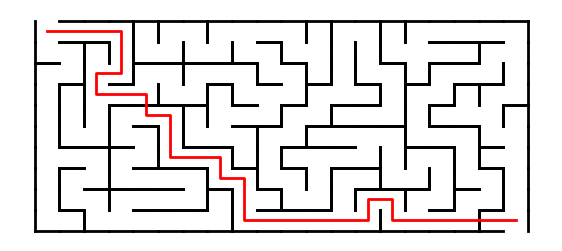

In [ ]:
solution = a_star(WallMazeSolver(M, 20))
plot_maze(M, figsize=(7,3), path=solution)

Second variant. What if the maze were a torus (i.e., a sort of donut, where opposite sides connect)? Could we have other solutions if we cross through walls?

In [ ]:
class ToroidalWallMazeSolver(HeuristicProblem):
  def __init__(self, maze, wallCost):
    self._maze = maze
    self._wallCost = wallCost

  def start(self):
    return (0,0)

  def next_moves(self, s):
    return neighbors4(s) # no limitations here

  def cost(self, s1, s2):
    return 1 if edge(s1,s2) in self._maze.edges else self._wallCost

  def heuristic(self, s):
    return (abs((s[0]-(self._maze.width- 1))%self._maze.width ) +
            abs((s[1]-(self._maze.height-1))%self._maze.height) )

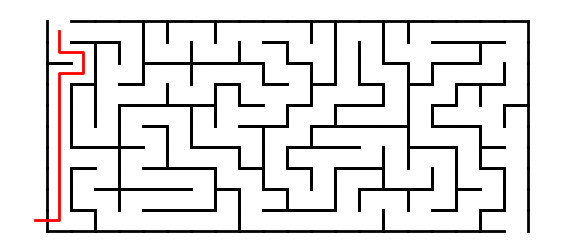

In [ ]:
solution = a_star(ToroidalWallMazeSolver(M, 20))
plot_maze(M, figsize=(7,3), path=solution)

If the cost of crossing walls were slightly lower, we would have a rather unique solution.

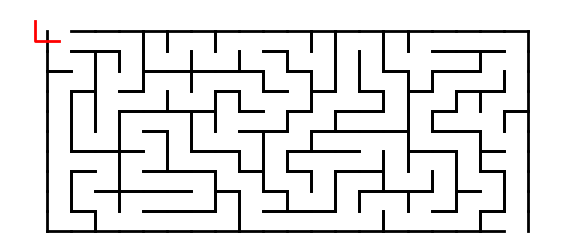

In [ ]:
solution = a_star(ToroidalWallMazeSolver(M, 10))
plot_maze(M, figsize=(7,3), path=solution)

The $A^*$ algorithm presents us with an interesting approach to incorporating problem information into the search. A good heuristic allows for an effective exploration of solution space.

However, we should not forget the potential size of the solution space. Let $d$ be the length of the best path to the solution, and $b$ be the average number of states to explore. In that case, the complexity of this search is $\sum_{i=0}^d b^i \in \mathcal{O}(b^d)$, an exponential complexity in the size of the solution.

The importance of a good heuristic is reflected in how it can reduce the value of $b$. Ideally, a perfect heuristic (an Oracle) would always tell us the best option to take. In that case, the search would become an algorithm with a complexity $\mathcal{O}(d)$.

In general, assuming the solution space is a tree and having access to a reasonable heuristic (that meets certain conditions), the search algorithm has polynomial complexity.



---



## Exercises

<font size="+4" color="blue;green"><b>?</b></font> Define function `missing` that, given a sorted list of non-negative integers, returns the smallest number that does not appear in the list.

For example, in the list `[0,1,2,6,7,9]`, the first missing value is the number `3`.

The function should have logarithmic complexity.

In [ ]:
def search(L, R, p, next_):
  while True:
    m = next_(L,R) # computes the next element to search
    if m is None:
      break        # the search ended
    if p(m):       # if m satisfies p,
      R = m        #   search [L,m]
    else:          # otherwise,
      L = m        #   search [m,R]
  return L,R

def missing(xs):
  ...

In [ ]:
assert missing([0, 1, 2, 6, 9, 11, 15]) == 3
assert missing([1, 2, 3, 6, 9, 11, 15]) == 0

In [ ]:
# the smallest missing number would be the index of the element
# which is not equal to its element
def missing(xs):
  mid = lambda L,R: (L+R)//2 if R-L>1 else None
  p   = lambda i: xs[i]!=i
  L, R  = search(-1, len(xs), p, mid)
  return R if R < len(xs) else None



---



**Exponential search** is an improvement over binary search, where the search begins by first finding a search range before executing a binary search for an element $y$.

The algorithm starts by checking 1, 2, 4, 8, ... indices to the right until it finds an element smaller than $y$. Let $i$ be the first index for which there is a value greater than $y$. Once the range is defined, a binary search is performed between indices $i/2$ and $i$.

This algorithm is $\mathcal{O}(\log i)$, where $i$ is the index of $y$ (if it is, or would have been, in the list), while binary search is $\mathcal{O}(\log n)$, where $n$ is the size of the list.

<font size="+4" color="blue;green"><b>?</b></font> Implement exponential search.

In [ ]:
def binary_search(xs, y, i, j):
  while i <= j:
    mid = (i+j)//2
    if xs[mid] == y:
      return mid
    if xs[mid] < y:
      i = mid+1
    else:
      j = mid-1
  return None

def exponential_search(xs, y):
  ...

In [ ]:
xs = [1,4,7,9,11,14,20,60]
for i,x in enumerate(xs):
  assert exponential_search(xs, x) == i
assert exponential_search([1,4,7,9], 5) == None



---



<font size="+4" color="blue;green"><b>?</b></font> Research how [interpolation search](https://en.wikipedia.org/wiki/Interpolation_search) works and implement it in Python.

In [ ]:
def interpolation_search(xs, y):
  ...

In [ ]:
xs = [1,4,7,9,11,14,20,60]
for i,x in enumerate(xs):
  assert interpolation_search(xs, x) == i
assert interpolation_search([1,4,7,9], 5) == None



---



<font size="+4" color="blue;green"><b>?</b></font> Use backtracking to implement the problem of returning all combinations of $k$ elements from a given sequence.

In [ ]:
class Combinations(BacktrackProblem):
  ...

In [ ]:
for sol in backtrack(Combinations('abcdef', 3)):
  print(''.join(sol), end= ' ')

print()
for sol in backtrack(Combinations([1,2,3,4,5], 2)):
  print(sol, end=' ')

abc abd abe abf acd ace acf ade adf aef bcd bce bcf bde bdf bef cde cdf cef def 
(1, 2) (1, 3) (1, 4) (1, 5) (2, 3) (2, 4) (2, 5) (3, 4) (3, 5) (4, 5) 



---



<font size="+4" color="blue;green"><b>?</b></font> Define class `TokensSumTo` that, given a positive integer `total`, a positive integer `n`, and a list of positive integers `xs`, is able to return lists with `n` elements from `xs` that sum to `total`. Search via backtracking.

For example, for `total=20`, `n=4`, and `xs = [2,5,8,10])`, there are the following solutions: `(2, 2, 8, 8), (2, 5, 5, 8), (5, 5, 5, 5)`.

In [ ]:
class TokensSumTo(BacktrackProblem):
  ...

In [ ]:
for sol in backtrack(TokensSumTo(20, 4, [2,5,8,10])):
  print(sol)

(2, 2, 8, 8)
(2, 5, 5, 8)
(5, 5, 5, 5)




---



Define function `partitions` that, given a sequence of values and integer $k$, partition the sequence into $k$ parts. The function should return a list with all possible solutions.

In [ ]:
class Partitions(BacktrackProblem):
  ...

In [ ]:
for xs in sorted(partitions([1,2,3,4,5], 3)):
  print(*xs)

for xs in sorted(partitions('abcdefg', 4)):
    print(*xs)

[1] [2] [3, 4, 5]
[1] [2, 3] [4, 5]
[1] [2, 3, 4] [5]
[1, 2] [3] [4, 5]
[1, 2] [3, 4] [5]
[1, 2, 3] [4] [5]
a b c defg
a b cd efg
a b cde fg
a b cdef g
a bc d efg
a bc de fg
a bc def g
a bcd e fg
a bcd ef g
a bcde f g
ab c d efg
ab c de fg
ab c def g
ab cd e fg
ab cd ef g
ab cde f g
abc d e fg
abc d ef g
abc de f g
abcd e f g




---



Given a positive integer $n$, a multiplicative partition is a sequence of divisors of $n$ whose product results in $n$.

For example, the multiplicative partitions of $12$ are $(2, 2, 3), (2, 6), (3, 4), (12)$.

The following helper function computes the divisors of a given positive integer:

In [ ]:
def divisors(n):
  """ returns list of divisors de n, except 1 """
  return [i for i in range(2,1+n//2) if n%i==0] + [n] if n>1 else []

<font size="+4" color="blue;green"><b>?</b></font> Define class `multiplicativePartitions` that, given a positive integer $n$, computes its multiplicative partitions. Use backtracking.

In [ ]:
class MultiplicativePartitions(BacktrackProblem):
  .

In [ ]:
for sol in backtrack(MultiplicativePartitions(24)):
  print(sol.candidate, end= ' ')
# should print (3, 2, 2, 2) (4, 3, 2) (6, 2, 2) (6, 4) (8, 3) (12, 2) (24,)



---



Let's consider triangles made from matches, as shown in the following image:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/backtrack_triangle_match.png' width=350px></center>

Assume you have a box with $n \geq 3$ matches. How many triangles can we form (you don't need to use all the matches), assuming that each side of the triangle is composed of an integer number of matches?

For example, with seven matches, we have the following solutions: $(1,1,1),(1,2,2),(1,3,3),(2,2,2),(2,2,3)$.

<font size="+4" color="blue;green"><b>?</b></font> Use backtracking to find all solution triplets for a given $n$ matches.

In [ ]:
class TriangleMatches(BacktrackProblem):
  ...

In [ ]:
for sol in backtrack(TriangleMatches(7)):
  print(sol, end= ' ')

(1, 1, 1) (1, 2, 2) (1, 3, 3) (2, 2, 2) (2, 2, 3) 



---



It is possible to arrange, for certain values of $n$, the first $n$ natural numbers in such a way that the sum of two consecutive numbers is always a square [[1](https://math.stackexchange.com/questions/1676413/for-which-n-can-1-2-n-be-rearranged-so-that-the-sum-of-each-two-adjacent)]. The values of $n$ for which this is valid are:

$$n = 15,16,17,23,25,26,27,28,29, \ldots$$

The following image shows a solution for $n=35$,

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/sum_adjacent_squares.jpg' width=400px></center>

<font size="+4" color="blue;green"><b>?</b></font> Use backtracking to find, given $n$, a solution for this problem.

<!--
ref: https://math.stackexchange.com/questions/1676413
ref: https://math.stackexchange.com/questions/1169177
ref: https://oeis.org/A090461
ref: https://math.stackexchange.com/questions/1168983
-->

In [ ]:
class PerfectSquareSequence(BacktrackProblem):
  ...

In [ ]:
for n in range(15,30):
  try:
    print(n, ':', next(backtrack(PerfectSquareSequence(n))))
  except:
    print(n, ': ()') # no solution found

15 : (8, 1, 15, 10, 6, 3, 13, 12, 4, 5, 11, 14, 2, 7, 9)
16 : (8, 1, 15, 10, 6, 3, 13, 12, 4, 5, 11, 14, 2, 7, 9, 16)
17 : (16, 9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8, 17)
18 : ()
19 : ()
20 : ()
21 : ()
22 : ()
23 : (2, 23, 13, 12, 4, 21, 15, 10, 6, 19, 17, 8, 1, 3, 22, 14, 11, 5, 20, 16, 9, 7, 18)
24 : ()
25 : (2, 23, 13, 12, 24, 25, 11, 14, 22, 3, 1, 8, 17, 19, 6, 10, 15, 21, 4, 5, 20, 16, 9, 7, 18)
26 : (2, 14, 22, 3, 13, 23, 26, 10, 6, 19, 17, 8, 1, 15, 21, 4, 12, 24, 25, 11, 5, 20, 16, 9, 7, 18)
27 : (1, 8, 17, 19, 6, 3, 13, 12, 24, 25, 11, 14, 22, 27, 9, 16, 20, 5, 4, 21, 15, 10, 26, 23, 2, 7, 18)
28 : (1, 15, 10, 26, 23, 13, 3, 6, 19, 17, 8, 28, 21, 4, 12, 24, 25, 11, 5, 20, 16, 9, 27, 22, 14, 2, 7, 18)
29 : (1, 24, 25, 11, 5, 4, 12, 13, 3, 6, 19, 17, 8, 28, 21, 15, 10, 26, 23, 2, 14, 22, 27, 9, 16, 20, 29, 7, 18)




---



<font size="+4" color="blue;green"><b>?</b></font> Given a list of matches of various sizes, we want to distribute them in a way that produces a square.

For example, if the list of match sizes is `1,1,2,2,2`, one solution is as follows:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/backtrack_square_match.png' width=200px></center>

Implement a backtracking search that produces all possible solutions. Avoid returning solutions that are the same by rotating the square.

The next code defines a representation for the state (`St` namedtuple). A state, herein, consists of the current distribution of the matches on the sides of the square (a tuple of four tuples) and another tuple with the matches yet to be distributed.

It also provides an auxiliary function that adds a match to one of the sides of the square.

In [ ]:
from collections import namedtuple

# square : a tuple of 4 tuples defining the size matches of each square side
# matches: a tuple with the remaining matches to place
St = namedtuple('St', 'square matches')

def add_match(square, n, new_match):
  """ helper function: adds a match to the n-th square's edge """
  new_square = tuple()
  for i in range(4):
    if i == n:
      new_square += (square[i] + (new_match,),)
    else:
      new_square += (square[i],)
  return new_square

In [ ]:
class SquareMatches(BacktrackProblem):
  ...

In [ ]:
for sol in backtrack(SquareMatches([1,1,2,2,2])):
  print(*sol.square)

(1, 1) (2,) (2,) (2,)


In [ ]:
for sol in backtrack(SquareMatches([1,4,5,1,2,2,3,2,2,2,1,1,1,1])):
  print(*sol.square)

(2, 2, 2, 1) (3, 2, 2) (4, 1, 1, 1) (5, 1, 1)
(2, 2, 2, 1) (3, 2, 1, 1) (4, 2, 1) (5, 1, 1)
(2, 2, 2, 1) (3, 2, 1, 1) (4, 1, 1, 1) (5, 2)
(2, 2, 2, 1) (3, 1, 1, 1, 1) (4, 2, 1) (5, 2)
(2, 2, 1, 1, 1) (3, 2, 2) (4, 2, 1) (5, 1, 1)
(2, 2, 1, 1, 1) (3, 2, 2) (4, 1, 1, 1) (5, 2)
(2, 2, 1, 1, 1) (3, 2, 1, 1) (4, 2, 1) (5, 2)
(2, 1, 1, 1, 1, 1) (3, 2, 2) (4, 2, 1) (5, 2)
(2, 2, 1, 1, 1) (2, 2, 2, 1) (4, 3) (5, 1, 1)
(2, 2, 1, 1, 1) (2, 2, 1, 1, 1) (4, 3) (5, 2)
(2, 1, 1, 1, 1, 1) (2, 2, 2, 1) (4, 3) (5, 2)




---



This is a puzzle from a children's math book.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/math-grade.jpg' width=350px></center>

The task is to find a solution using numbers from 1 to 9, without repetitions, such that the sums of the rows, columns, and diagonals match the given totals.

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Specify this problem in a `BacktrackProblem` object. Use the `backtrack` function to find a solution.

<details>
<summary><font color='green'>Hint</font></summary>
The `reject` method is the most complicated. Each new number placed must satisfy the various constraints it participates in. For example, the 7th number must validate the first column, the positive diagonal, and the third row.
</details>

In [ ]:
class Puzzle1to9(BacktrackProblem):
  ...

In [ ]:
# totals, from the right upper corner to the left lower corner
totais = [10,20,14,11,20,20,10,15]

for solution in backtrack(Puzzle1to9(totais)):
   print(*solution[ :3])
   print(*solution[3:6])
   print(*solution[6: ])

9 6 5
4 3 7
2 1 8




---



A magic square is a $3 \times 3$ grid with numbers from $1$ to $9$ where all rows, columns, and the two main diagonals sum to $15$.

<font size="+4" color="blue;green"><b>?</b></font> Define function `magicSquares` that generates valid solutions for magic squares using backtracking.

In [ ]:
def magicSquares():
  ...

In [ ]:
for solution in magicSquares():
   print(*solution[ :3])
   print(*solution[3:6])
   print(*solution[6: ])
   print('-'*5)

2 7 6
9 5 1
4 3 8
-----
2 9 4
7 5 3
6 1 8
-----
4 3 8
9 5 1
2 7 6
-----
4 9 2
3 5 7
8 1 6
-----
6 1 8
7 5 3
2 9 4
-----
6 7 2
1 5 9
8 3 4
-----
8 1 6
3 5 7
4 9 2
-----
8 3 4
1 5 9
6 7 2
-----




---



<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Consider the problem of covering a rectangle of size $n \times m$ with up to $k$ smaller rectangles (in an integer grid). Our goal is to enumerate the possible solutions.

For example, for a $3 \times 2$ rectangle with $k=3$, these are the solutions:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/rectangle_cover.png' width=600px></center>

Use backtracking to find all possible solutions.

<details>
<summary><font color='green'>Hint</font></summary>
The representation of the state is crucial to facilitate implementation. Your state should contain at least three pieces of information: the value of $k$, a sequence of rectangles already used inside the main rectangle (each rectangle can be a tuple), and the area that still needs to be filled. The `next_moves` function should find the next square not yet occupied (consider the main rectangle as a grid of 1x1 squares) and try to use that square as the corner of all possible rectangles to make (considering only the remaining unoccupied area).
</details>

In [ ]:
class Rectangles(BacktrackProblem):

  def __init__(self, w, h, k):
    self.w = w
    self.h = h
    self.k = k

  def start(self):
    ...

  def reject(self, st):
    ...

  def accept(self, st):
    ...

  def next_moves(self, st):
    ...

In [ ]:
assert len(list(backtrack(Rectangles(3,2, 3)))) == 13
assert len(list(backtrack(Rectangles(4,3, 4)))) == 140
assert len(list(backtrack(Rectangles(3,3, 5)))) == 163
assert len(list(backtrack(Rectangles(4,3,10)))) == 3146

A suggested state representation for the problem could be as follows:

In [ ]:
from collections import namedtuple

## Problem State
# w, width
# h, height
# k, rectangles left to use
# area, area left
# rs, tuple of rectangles ordered by upper-left corner (x,y)
#     each rectangle is defined by (corner_x,corner_y,width_x,height_y)
St = namedtuple('St', 'w h k area rs')

If you use this state, execute the following function to visualize your results using `matplotlib`:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def showRects(rects, per_column=1):
  width_rect, height_rect = rects[0].w+1.25, rects[0].h+1.25
  height_grid = height_rect * (1+(len(rects)//per_column))

  fig, ax = plt.subplots(figsize=(16,10))
  plt.axis('off')                    # remove axis
  plt.axis('equal')                  # axis on same scale
  plt.ylim(height_grid, 0)           # invert y axis
  ax.plot(width_rect*per_column, height_grid)
  ax.get_xaxis().set_visible(False)  # remove axis numbers
  ax.get_yaxis().set_visible(False)

  rects.sort(key=lambda st: len(st.rs))
  for i,rect in enumerate(rects):    # draw rectangles
    for x,y,dx,dy in rect.rs:
      ax.add_patch(Rectangle((x +  width_rect*(i %per_column),
                              y + height_rect*(i//per_column)),
                   dx, dy, fill=False))

Here's the solution for a different problem instance:

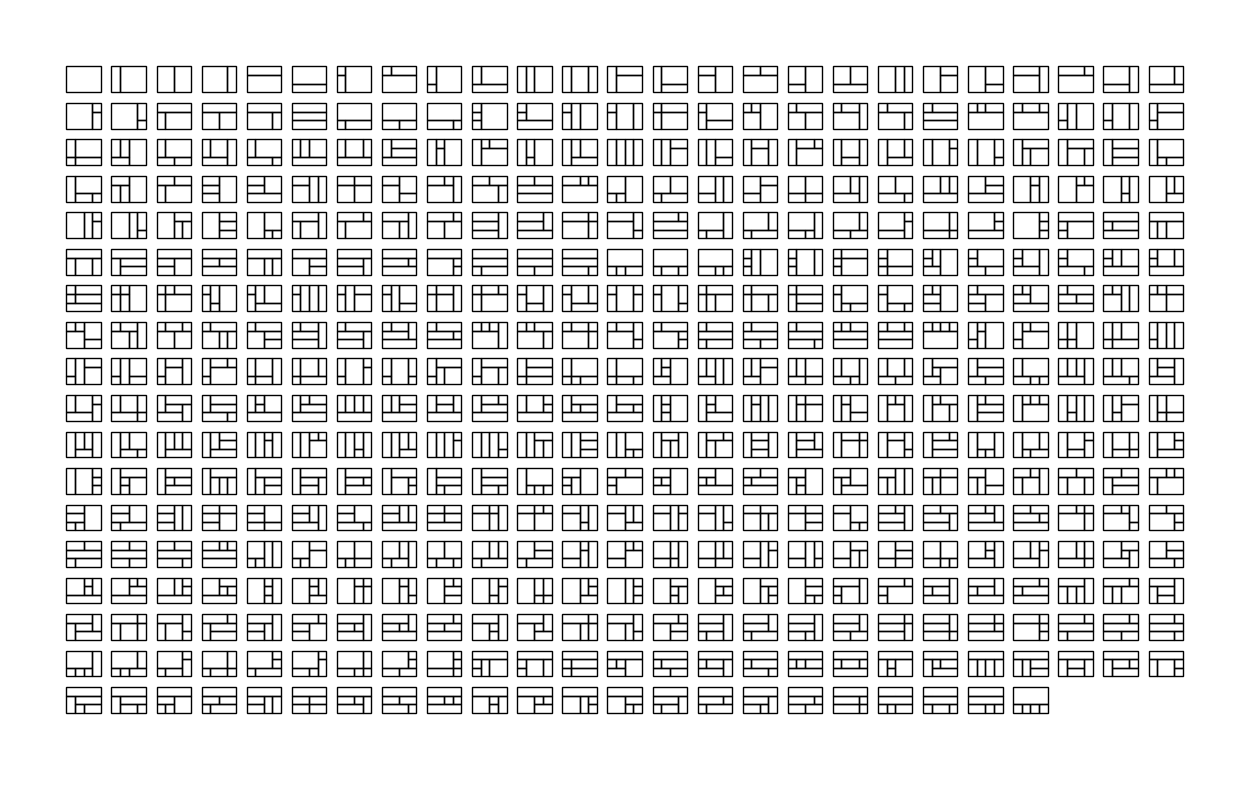

In [ ]:
rects = list(backtrack(Rectangles(4,3,5)))
showRects(rects, per_column=25)



---



<font size="+4" color="blue;green"><b>?</b></font> Reimplement the matches problem by defining a suitable `TreeSearchProblem` class.

In [ ]:
class TriangleMatches(TreeSearchProblem):
  ...

In [ ]:
for sol in bfs(TriangleMatches(17)):
  print(sol[-1], end=' ')

(1, 1, 1) (1, 2, 2) (1, 3, 3) (1, 4, 4) (1, 5, 5) (1, 6, 6) (1, 7, 7) (1, 8, 8) (2, 2, 2) (2, 2, 3) (2, 3, 3) (2, 3, 4) (2, 4, 4) (2, 4, 5) (2, 5, 5) (2, 5, 6) (2, 6, 6) (2, 6, 7) (2, 7, 7) (2, 7, 8) (3, 3, 3) (3, 3, 4) (3, 3, 5) (3, 4, 4) (3, 4, 5) (3, 4, 6) (3, 5, 5) (3, 5, 6) (3, 5, 7) (3, 6, 6) (3, 6, 7) (3, 6, 8) (3, 7, 7) (4, 4, 4) (4, 4, 5) (4, 4, 6) (4, 4, 7) (4, 5, 5) (4, 5, 6) (4, 5, 7) (4, 5, 8) (4, 6, 6) (4, 6, 7) (5, 5, 5) (5, 5, 6) (5, 5, 7) (5, 6, 6) 



---



<font size="+4" color="blue;green"><b>?</b></font> Define class `GenerateParens`, a subclass of `TreeSearchProblem`, which, given a positive integer $n$, returns an object that can be used by a tree search to generate all well-formed combinations of $n$ pairs of parentheses.

For example, for $n=3$, the valid combinations are `((()))`, `(()())`, `(())()`, `()()()`.

In [ ]:
class GenerateParens(TreeSearchProblem):
  ...



---



The following list encodes the roads that connect cities. The index `i` in the list identifies the roads that depart from that city. Each number in that list represents the index of the destination city.

In [ ]:
roads = [[1,2,4], [3,4,1], [3], [4], []]

In the previous example, the first city (index zero) has roads that connect to the second, third, and fifth (the last) city.

We want to find all possible paths that, given a list of roads, connect the first city to the last city.

<font size="+4" color="blue;green"><b>?</b></font> Specify this problem in a `TreeSearchProblem` object. Try to solve it using both BFS and DFS.

In [ ]:
class CityPaths(TreeSearchProblem):
  ...

In [ ]:
for path in bfs(CityPaths(roads)):
  print(path[-1], end=' ')
print()
for path in dfs(CityPaths(roads)):
  print(path[-1], end=' ')

(0, 4) (0, 1, 4) (0, 1, 3, 4) (0, 2, 3, 4) 
(0, 4) (0, 2, 3, 4) (0, 1, 4) (0, 1, 3, 4) 



---



Given a string `s`, we wish to find all strings that can be made using at least one of the letters from `s`.

For example, for the string `AAB`, the options are `'A', 'AA', 'AAB', 'AB', 'ABA', 'B', 'BA', 'BAA'`.

<font size="+4" color="blue;green"><b>?</b></font> Specify this problem in a `TreeSearchProblem` object.

In [ ]:
class Words(TreeSearchProblem):
  ...



---



An expedition of three missionaries and three cannibals arrives at the river's edge. There is a boat to cross the river, but it can only carry two people. Provide a sequence of trips to get everyone to the opposite bank, with the restriction that the missionaries cannot be in the minority on either bank, i.e., 🙏 $\not \lt$ 🦴

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Implement a solution using backtracking.

<details>
<summary><font color='green'>Hint</font></summary>
  The main work will be in the <code>next_moves</code> method, which must follow the rules described in the problem statement. Don't forget to include in your state which side of the river the boat is on.
</details>

In [ ]:
class Cannibals(BacktrackProblem):
  ...

In [ ]:
# solution with a specific state (you might prefer another state)
solution = next(backtrack(Cannibals(3, 3)))
for m1,c1,boat,m2,c2 in solution:
  boat = '⛵🌊🌊' if boat<0 else '🌊🌊⛵'
  m1, m2 = m1*'🙏'+(3-m1)*'🌼', m2*'🙏'+(3-m2)*'🌼'
  c1, c2 = c1*'🦴'+(3-c1)*'🌼', c2*'🦴'+(3-c2)*'🌼'
  print(f'{m1}{c1} {boat} {m2}{c2}')

🙏🙏🙏🦴🦴🦴 ⛵🌊🌊 🌼🌼🌼🌼🌼🌼
🙏🙏🌼🦴🦴🌼 🌊🌊⛵ 🙏🌼🌼🦴🌼🌼
🙏🙏🙏🦴🦴🌼 ⛵🌊🌊 🌼🌼🌼🦴🌼🌼
🙏🙏🙏🌼🌼🌼 🌊🌊⛵ 🌼🌼🌼🦴🦴🦴
🙏🙏🙏🦴🌼🌼 ⛵🌊🌊 🌼🌼🌼🦴🦴🌼
🙏🌼🌼🦴🌼🌼 🌊🌊⛵ 🙏🙏🌼🦴🦴🌼
🙏🙏🌼🦴🦴🌼 ⛵🌊🌊 🙏🌼🌼🦴🌼🌼
🌼🌼🌼🦴🦴🌼 🌊🌊⛵ 🙏🙏🙏🦴🌼🌼
🌼🌼🌼🦴🦴🦴 ⛵🌊🌊 🙏🙏🙏🌼🌼🌼
🌼🌼🌼🦴🌼🌼 🌊🌊⛵ 🙏🙏🙏🦴🦴🌼
🙏🌼🌼🦴🌼🌼 ⛵🌊🌊 🙏🙏🌼🦴🦴🌼
🌼🌼🌼🌼🌼🌼 🌊🌊⛵ 🙏🙏🙏🦴🦴🦴




---



<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Adapt the code from class `Rectangles` to calculate the minimum number of squares needed to cover a given rectangle. Use either breadth-first or depth-first search (choose the most suitable search for the problem).

In [ ]:
class MinSquares(TreeSearchProblem):
  def __init__(self, w, h):
    self.w = w
    self.h = h

  def start(self):
    ...

  def is_goal(self, st):
    ...

  def next_moves(self, st):
    ...

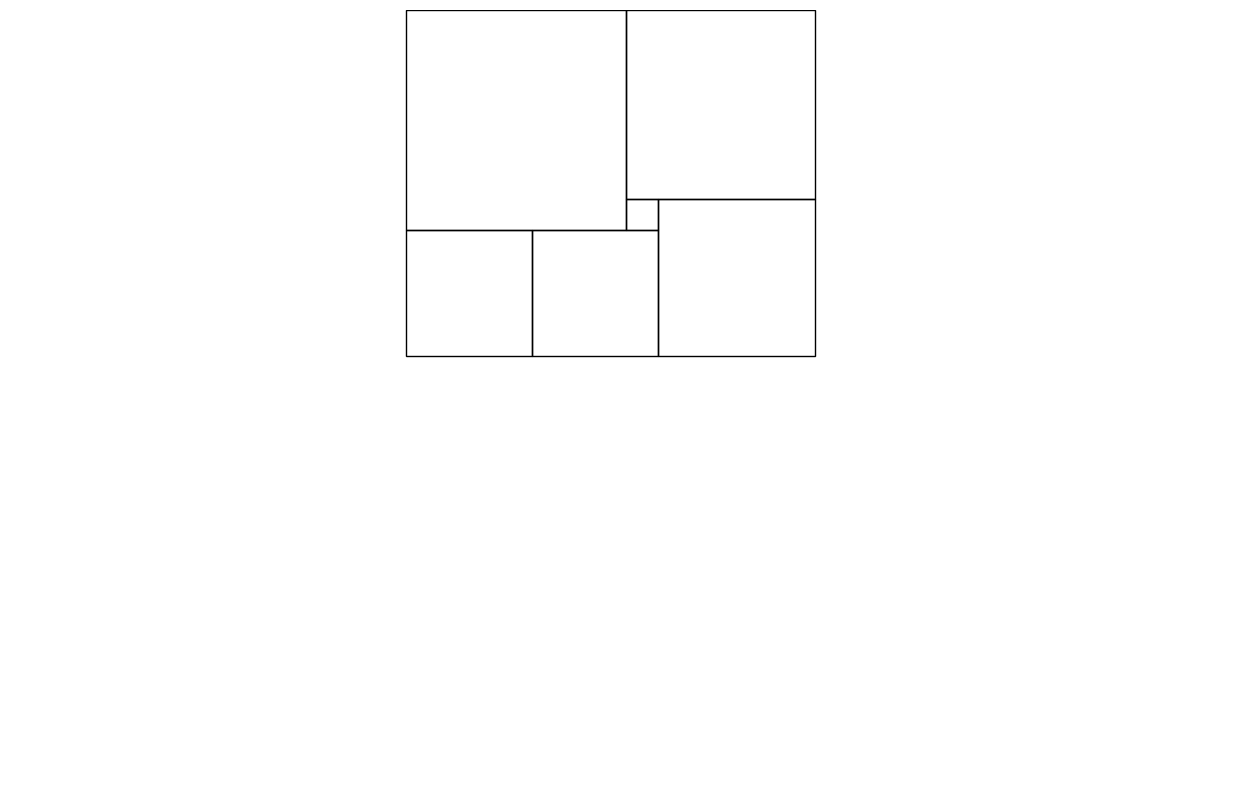

In [ ]:
gen = bfs(MinSquares(13,11))
sol = next(gen)[-1]
showRects([sol])

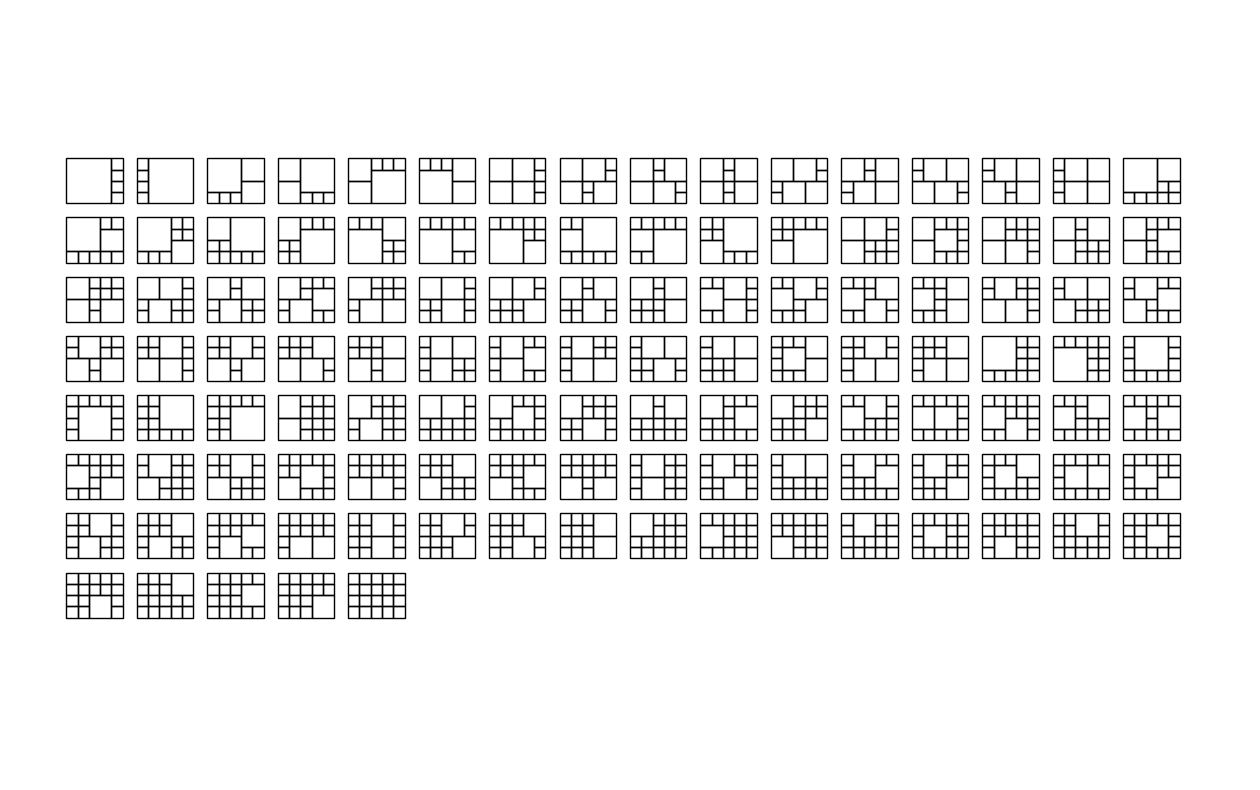

In [ ]:
# retorna todas as soluções, usando cada vez mais quadrados
sols = [sol[-1] for sol in bfs(MinSquares(5,4))]
showRects(sols, per_column=16)



---



Let's consider a grid composed of zeros and ones. Zeros represent mines, and ones represent free houses.

In [ ]:
grid = [[0,0,1,0,0,0,1,1,1,1],
        [0,0,1,0,0,0,1,0,0,0],
        [1,1,1,1,1,1,1,0,0,0],
        [1,1,1,1,0,0,0,0,0,0],
        [1,1,1,1,0,0,0,1,1,1],
        [0,0,0,1,0,0,0,1,1,1],
        [0,0,0,1,1,1,1,1,0,0],
        [0,0,0,1,0,0,0,1,0,0],
        [1,1,1,1,0,0,0,1,0,0],
        [1,1,1,1,0,0,0,1,1,1]]

We want to find the shortest path that takes us from the left column to the right column without passing over any mines.

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define class `SensorPath`, a subclass of `TreeSearchProblem`, with the specification of this problem.

To find the answer, should we use BFS or DFS?

<details>
<summary><font color='green'>Hint</font></summary>
The state should contain the path traveled so far so that the `next_moves` function can reject moves that produce cycles.
</details>

In [ ]:
class SensorPath(TreeSearchProblem):
  ...



---



Donald Knuth is one of the great names in Computer Science. His book _The Art of Computer Programming_ is considered one of the algorithmic bibles. This exercise is inspired by one of his conjectures, which claims that it is possible to express any positive integer starting from the number four using only the unary functions of square root, factorial, and floor.

For example,

$$\biggl\lfloor \sqrt{\sqrt{\sqrt{\sqrt{\sqrt{(4!)!}}}}} \biggr\rfloor = 5$$

This is an interesting problem as a search exercise because it is very easy to compute huge numbers, even for calculating small results. You can see more examples [here](https://oisinmoran.com/projects/root_floor_fact_four).

Let's develop a simpler variant. We also start with 4, but the available operations always produce integers (and don't grow as much!):

+ Integer square root (i.e., only returns the integer part of the square root)
+ Division by two
+ Summation from 1 up to the given value
+ Squaring the number

In [ ]:
ops = {'sqrt' : lambda x: int(x**0.5),
       'half' : lambda x: x//2,
       'sum'  : lambda x: x*(x+1)//2,
       'sq'   : lambda x: x*x,
      }

For example,

$$ \biggl(\bigl(\sum 4\bigr)/2\biggr)^2/2 = 12$$

<font size="+4" color="blue;green"><b>?</b></font> Define class `Knuth`, subclass of `TreeSearchProblem`, which specifies this problem.

One of the search methods, either BFS or DFS, cannot be used. Why?

In [ ]:
class Knuth(TreeSearchProblem):
  ...



---



We have access to a grid of non-zero integer values. These values indicate, for each position, an amount of gold that can be collected.

We can start at any position and move north, south, east, and west as many times as we want, as long as we follow the following rules:

+ When we are at a position, we collect all the gold at that position.

+ A position cannot be visited more than once.

+ Positions without gold cannot be visited.

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define class `MineGold`, subclass of `TreeSearchProblem`, that specifies the problem. Objects of this class receive a grid and can generate all valid paths and the respective collected gold. Use this information to find the path that maximizes gold collection.

In [ ]:
# two grid examples

grid =[[0,6,0],  # max gold: 24
       [5,8,7],  # path: 7 -> 8 -> 9
       [0,9,0]]

grid = [[1, 0, 7],  # max gold: 37
        [2, 0, 6],  # path: 7 -> 6 -> 8 -> 4 -> 12
        [3, 4, 8],
        [0,12, 0],
        [9, 0,33]]

In [ ]:
class MineGold(TreeSearchProblem):
  ...



---



Consider the following Sudoku puzzle.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/sudoku.jpg' width=400px></center>

We will represent a puzzle as a tuple of tuples. For example:

In [ ]:
puzzle = ((5,3,0,  0,7,0,  0,0,0),   # zero means empty cell
          (6,0,0,  1,9,5,  0,0,0),
          (0,9,8,  0,0,0,  0,6,0),

          (8,0,0,  0,6,0,  0,0,3),
          (4,0,0,  8,0,3,  0,0,1),
          (7,0,0,  0,2,0,  0,0,6),

          (0,6,0,  0,0,0,  2,8,0),
          (0,0,0,  4,1,9,  0,0,5),
          (0,0,0,  0,8,0,  0,7,9))

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define class `SudokuSolver`, subclass of `TreeSearchProblem`, that specifies the problem.

In this situation, would it make more sense to use BFS or DFS for the search?

To facilitate the implementation, predicate `is_valid` is available, which checks if a given partial state is valid according to Sudoku rules. We consider that a puzzle state is given as a tuple of tuples, as shown in the `puzzle` variable.

<details>
<summary><font color='green'>Hint</font></summary>
It is suggested to implement two auxiliary functions: `update`, which allows you to insert a number into a square, and `find_next_zero`, which returns the position of the next zero to modify.
</details>

In [ ]:
def invalid(row):
  ns = [cell for cell in row if cell !=0]
  return len(set(ns)) != len(ns)  # repeated numbers

def is_valid(state):
  for row in state:
    if invalid(row):
      return False
  for col in zip(*state):
    if invalid(col):
      return False
  for cx,cy in [(i,j) for i in [0,3,6] for j in [0,3,6]]:
    if invalid(state[cx+dx][cy+dy] for dx in [0,1,2] for dy in [0,1,2]):
      return False
  return True

In [ ]:
class SudokuSolver(TreeSearchProblem):
  ...



---



_blocks world_ is an example of a _toy problem_: i.e., simple problems used to test new techniques and compare them with existing solutions.

In this case, we are given a fixed set of stacks with some blocks arranged on them. The idea is to move blocks between columns in order to reach a given goal.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/block_world.png' width=800px></center>

The rules are:

+ You can only move one block at a time.

+ You can only move a block from the top of one stack to the top of another stack (which may be empty).

+ You can only move a block onto another block of smaller value.

In our case, the blocks will be represented by numbers. The goal is to place all the blocks in the first column.

The state will be represented by a tuple of tuples. Each of the inner tuples describes the blocks it contains. For example:

In [ ]:
# eg: this initial state...
### 6
### 5
### 1 2 4
### 3
# ...can be represented by this tuple:
world = ((6,), (5,), (1,2,4), (3,))

# The goal is to reach
### 1 2 3 4 5 6
###
###
###
# represented by tuple ((1,2,3,4,5,6), (), (), ())

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define class `BlocksWorld`, subclass of `HeuristicProblem`, that specifies the problem.

In [ ]:
class BlocksWorld(HeuristicProblem):
  ...

In [ ]:
solution = a_star(BlocksWorld(world))
for step in solution:
  for line in step:
    print('|', ' '.join([str(i) for i in line]))
  print('========')



---



The [15-puzzle](https://en.wikipedia.org/wiki/15_Puzzle) was a viral puzzle game in the mid-20th century, but it is still quite popular today. The game consists of a 4x4 grid with fifteen square tiles (numbered from 1 to 15) and one empty space through which adjacent tiles can be moved.

Here, we will solve a smaller variant, the 8-puzzle:

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/8_puzzle.png' width=250px></center>

Given any position, the goal is to place the tiles in ascending numerical order.

In [ ]:
# 2 3 8
# 1 6 4
# 7 0 5
initial = (2,3,8,  1,6,4,  7,0,5) # a position (0 is the empty space)

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define class `EightPuzzle`, a subclass of `HeuristicProblem`, specifying the problem.

<details>
<summary><font color='green'>Hint</font></summary>
Consider as a heuristic the count of numbers that are not in the correct position.
</details>

Note: About half of the initial positions are unsolvable (there is a [parity argument](https://en.wikipedia.org/wiki/15_puzzle#Solvability) that justifies this statement). In one of these positions, the `a_star` function should not terminate in an error, but instead return `None`.

In [ ]:
class EightPuzzle(HeuristicProblem):
  def __init__(self, initial, goal=(1,2,3, 4,5,6, 7,8,0)):
    self._initial = initial
    self._goal = goal

  ...

  # auxiliary funtion: moves a tile from index i to index j
  def move_tile(self, state, i, j):
    new_state = tuple()
    assert state[j] == 0
    for k,x in enumerate(state):
      if   k==i: new_state += (0,)
      elif k==j: new_state += (state[i],)
      else     : new_state += (state[k],)
    return new_state

In [ ]:
initial = (2,3,8,
           1,6,4,
           7,0,5)

solution = a_star(EightPuzzle(initial))
for step in solution:
  print(f'{step[:3]}\n{step[3:6]}\n{step[6:]}\n---------')



---



In the _Lights Out_ puzzle, you have a grid of lights, some of which are on and others off. Each time you turn on a light, the adjacent lights in the horizontal and vertical directions toggle their state (lights that were on turn off, and vice versa). The goal is to turn on all the lights.

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/lights_on.png' width=600px></center>

<font size="+4" color="blue;green"><b>?</b></font> <font size="+4" color="blue;green"><b>?</b></font> Define the `light_on` function that receives an initial game state and returns a `HeuristicProblem` object that can be used by the $A^*$ algorithm to find a solution to the problem.

Note: Some initial positions do not have a solution. In these cases, the `a_star` function should not terminate in an error but return `None`.

In [ ]:
class LightOn(HeuristicProblem):
  def __init__(self, initial):
    self._initial = initial
    self._n_rows = len(initial)
    self._n_cols = len(initial[0])

  ...

  # auxiliary function: returns adjacent cells (incl. itself)
  def neighbors(self, s, i, j):
    cells = [(i,j)]
    for dx, dy in [(+1,0), (-1,0), (0,+1), (0,-1)]:
      nx, ny = i+dx, j+dy                       # new position
      if 0 <= nx < self._n_rows and 0 <= ny < self._n_cols: # if new position is within bounds
        cells.append((nx,ny))
    return cells

  # auxiliary function: flips light (i,j) and its neighbors
  def flip(self, s, i, j):
    s2, neighbor_cells = tuple(), self.neighbors(s, i, j)
    for i in range(self._n_rows):
      row = tuple()
      for j in range(self._n_cols):
        if (i,j) in neighbor_cells:
          row += (1-s[i][j],) # flip 0 and 1
        else:
          row += (s[i][j],)   # not adjacent, so keeps the old value
      s2 += (row,)
    return s2

In [ ]:
initial = ((1,1,0),
           (0,1,0),
           (1,0,1))

solution = a_star(LightOn(initial))
for step in solution:
  print(f'{step[0]}\n{step[1]}\n{step[2]}\n---------')